In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "“backend" on line 1 in
/Users/kenfuliang/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def get_key(dic,val): 
    rt = []
    for key, value in dic.items(): 
        if val == value:
            rt.append(key)
    return rt
def visualizePolicy(gridWidth, gridHeight, goalState, trapStates, policy):
    patch=[]
    #grid height/width
    gridAdjust = 0.5
    gridScale = 1
    arrowScale = .2
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
#     plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
#     ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
#     ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
#     for (trapx, trapy) in trapStates:
#         ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
#     for x in xs:
#         draw = plt.plot([x, x], [ys[0], ys[-1]], color = "black")
#         patch.append(draw)
#     for y in ys:
#         draw = plt.plot([xs[0], xs[-1]], [y, y], color = "black")
#         patch.append(draw)

    #labeled values
#     for (statex, statey), actionDict in policy.items():
#         for (optimalActionX, optimalActionY), actionProb in actionDict.items():
#             plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
    for (state, action),actionProb in policy.items():
        statex,statey = state
        optimalActionX,optimalActionY = action
#         print(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale)
        if actionProb!=0:
            draw = plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
            patch.append(draw)
    return patch

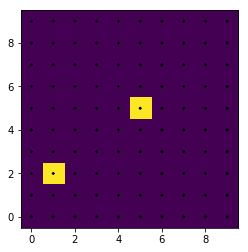

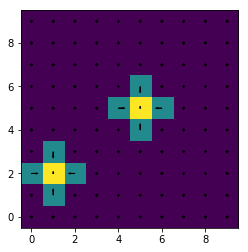

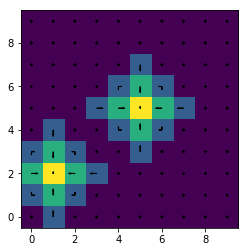

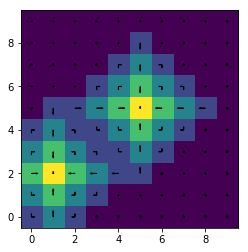

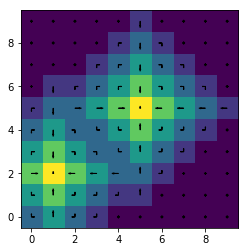

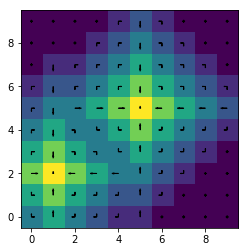

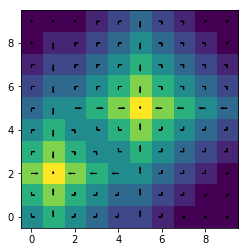

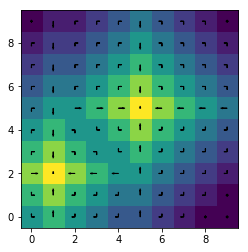

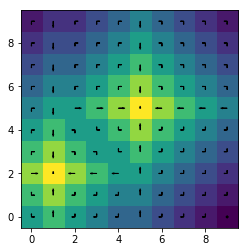

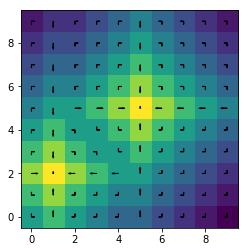

In [3]:
## basic grid world ice cream scearch 
## Define env
H_X, H_Y = 10,10 # map size
states = ([tuple((xx,yy)) for xx in range(H_X) for yy in range(H_Y)])
actions = (tuple((0,-1)),tuple((0,1)),tuple((1,0)),tuple((-1,0)),tuple((0,0)))
Store_D, Store_S = tuple((5,5)), tuple((1,2)) ## store position
gamma = 0.9

def TransitionP(s0,a0,correctProb=1):    
    s1 = np.array(s0)+np.array(a0)
    if(s1[0]<0 or s1[0]==H_X):
        s1[0] = s0[0]
    if(s1[1]<0 or s1[1]==H_Y):
        s1[1] = s0[1]
    return tuple(s1)


def rewardF(s0,a,s1):
    if (s1==Store_D and s0==Store_D) or (s1==Store_S and s0==Store_S):
        return 1
    else :
        return 0

def ValueIteration(value):
    value_pre = value.copy()
    value_next = np.zeros_like(value_pre)
    for s in states:
        Q = {a: 0 for a in actions}
        for a in actions:
            next_s = TransitionP(s,a)
            Q[a] = (rewardF(s,a,next_s) + gamma*value_pre[next_s])
        value_next[s] = max(Q.values())
    return value_next

def PolicyIteration(value):
    # init policy 
    policy = {(s,a):0 for s in states for a in actions}
    for s in states:
        max_value = -np.inf
        for a in actions:
            s1 = TransitionP(s,a) 
            max_value = max(max_value, value[s1])
            
        acts = []
        for a in actions:
            s1 = TransitionP(s,a) 
#             print(s,a,s1)
            if max_value == value[s1]:
                acts.append(a)
                
#         acts = get_key(value[s],max_value)
        for a in acts:
            policy[(s,a)] = 1/len(acts)
    return policy
    
def VisualizeValue(value):
    plt.imshow(value.T,origin='lower',)
#     plt.show()
    
def VisualizePolicy(policy):
    return 

# init value table 
value = np.zeros((H_X,H_Y))
value_history = []
policy_history = []
for _ in range(10):

    policy = PolicyIteration(value)
    value = ValueIteration(value) 
    visualizePolicy(10,10,Store_D,[0],policy)
    VisualizeValue(value)
    plt.show()
    value_history.append(value)
    policy_history.append(policy)


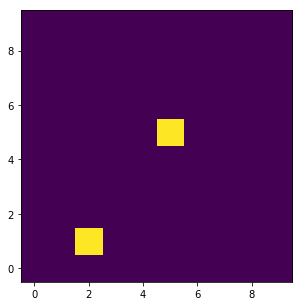

In [4]:
from matplotlib import animation
# %matplotlib qt
fig=plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(-0.5, 9.5), ylim=(-0.5, 9.5))
im = plt.imshow(np.zeros((10,10)))
# initialization function: plot the background of each frame
def init():
    im.set_data(value_history[0])
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=value_history[i]
    im.set_array(a)
    im.autoscale()
    
#     patch = plt.Arrow(0, 0,1,1)
#     ax.add_patch(patch)
#     patch = plt.Arrow(1, 1,2,1)
#     ax.add_patch(patch)
#     patch = visualizePolicy(10,10,Store_D,[0],policy_history[i])
#     for pp in patch:
#         ax.add_patch(pp)
    return [im]
anim = animation.FuncAnimation(fig, animate,
                               frames=10, interval=100, blit=True)

In [5]:
from IPython.display import HTML
HTML(anim.to_html5_video())